In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Prawesh March 2023

Mounted at /content/drive


In [2]:

import glob
import os
import numpy as np
from scipy.io import savemat,loadmat
import matplotlib.pyplot as plt


# Region Labels

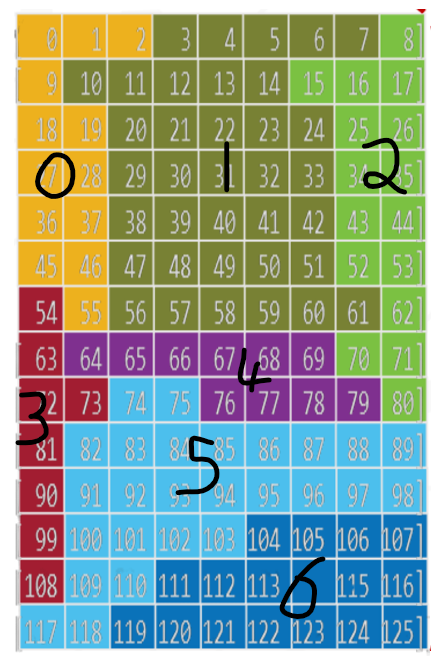

# Data Loading

In [3]:
import tensorflow as tf
import numpy as np
import glob

# Define the path to your data files
data_path = "/content/drive/MyDrive/Spindles/Raw_Data/forPID/OR17/Hilbert_norm/20200220_0um_posttrain*.npz"

# Create a list of all data file paths
data_files = glob.glob(data_path)


def load_data(file_path):
    with np.load(file_path) as data:
        x = data["x"]
        y = data["y"]
    return x, y

x_data = np.empty((0, 126), dtype=np.float64)
y_data = np.empty((0, 1), dtype=np.float64)

for file_path in data_files:
    x, y = load_data(file_path)
    x_data = np.concatenate([x_data, x], axis=0)
    y_data = np.concatenate([y_data, y[:,None]], axis=0)


# Initial PCA anlaysis based on local/global power based split

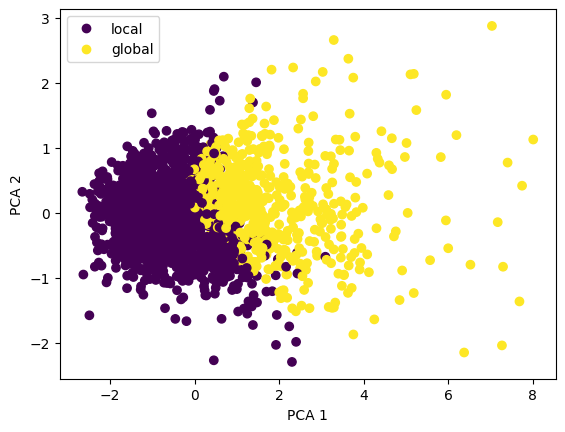

In [5]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca_data = pca.fit_transform(x_data)

pca1 = pca_data[:, 0]
pca2 = pca_data[:, 1]
scatter=plt.scatter(pca1, pca2,c=y_data)
lgnd=scatter.legend_elements()[0]
plt.legend(handles=[lgnd[0],lgnd[-1]], labels=['local','global',"d"])


plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


# Calculate Power Metric

In [7]:

A0=[0,1,2,9,18,19,27,28,36,37,45,46,55]
A1=[3, 4, 5, 6, 7,10, 11, 12, 13, 14,20, 21, 22, 23, 24,29, 30, 31, 32, 33,38, 39, 40, 41, 42,47, 48, 49, 50, 51,56, 57, 58, 59, 60, 61]
A2=[8,15,16,17,25,26,34,35,43,44,52,53,62,70,71,80]
A3=[54,63,72,73,81,90,99,108]
A4=[64, 65, 66, 67, 68, 69,76, 77, 78, 79]
A5=[74,75,82, 83, 84, 85, 86, 87, 88, 89,91, 92, 93, 94, 95, 96, 97, 98,100, 101, 102, 103,109,110,117,118]
A6=[104, 105, 106, 107,111, 112, 113, 114, 115, 116,119, 120, 121, 122, 123, 124, 125]

B1=[18,19,20,21,27,28,29,36,37,45,46,54,55,63,64,65,72,73,81,82]
B2=[4,5,6,7,8,14,  15,  16,  17,23,  24,  25,  26,32,  33,  34,  35,42,  43,  44,53,62,71,80]
B3=[94,95,102,103,104,96,105]

path="/content/drive/MyDrive/Spindles/Raw_Data/forPID/OR17/20200220_0um_posttrain"
Areas=[A0,A1,A2,A3,A4,A5,A6]
AgArea=[B1,B2,B3]
spindle_path=path+'_Hilbert_features.mat'

spindle_raw=loadmat(spindle_path)
hilbPow=(np.hstack(np.concatenate(spindle_raw["Hilbert"]['pow']))).T
regionPower=np.zeros((hilbPow.shape[0],7))
for i,A in enumerate(AgArea):
    #idx=np.unravel_index(A, (14,9))

    regionPower[:,i]=hilbPow[:,A].max(1)

#regionPower=regionPower/regionPower.max(1)[:,None]
# regionPower=regionPower==1
maxRP=regionPower.argmax(1)
idx=np.argsort(regionPower)
#plt.plot(regionPower[0])
#pow_img=hilbPow[0].reshape((14,9))
#plt.imshow(pow_img,cmap='jet')


In [8]:
from scipy.ndimage import generic_filter
r = 1
c = 1

hilSmo=np.empty_like(hilbPow)
for i in range(len(hilbPow)):
    hilSmo[i] = (generic_filter(hilbPow[i].reshape(14,9), np.mean, size=(2*r+1, 2*c+1))).reshape(-1,126)

regionPower=np.zeros((hilSmo.shape[0],7))
for i,A in enumerate(AgArea):
    #idx=np.unravel_index(A, (14,9))

    regionPower[:,i]=hilSmo[:,A].max(1)

#regionPower=regionPower/regionPower.max(1)[:,None]
# regionPower=regionPower==1
maxRP=regionPower.argmax(1)
idx=np.argsort(regionPower)

# PCA anlaysis labelled on power metric: Can clearly see the gradient

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


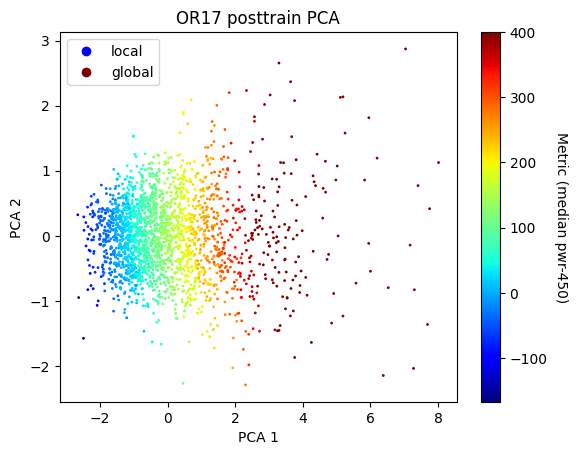

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=2)

# Fit K-means to the data
kmeans.fit(pca_data)

# Get cluster assignments for each data point
cluster_labels = kmeans.labels_

# Get the coordinates of the cluster centers
cluster_centers = kmeans.cluster_centers_
plt.style.use('default')

# Plot the data points and cluster centers
scatter=plt.scatter(pca_data[:, 0], pca_data[:, 1], c=y_data, s=1, cmap='jet',vmax=400)
cbar = plt.colorbar(scatter)
cbar.set_label('Metric (median pwr-450)', rotation=270, labelpad=15)
lgnd=scatter.legend_elements()[0]
plt.legend(handles=[lgnd[0],lgnd[-1]], labels=['local','global',"d"])

# plt.scatter(cluster_centers[:, 1], cluster_centers[:, 2], marker='x', s=200, linewidths=3, color='r')

plt.title("OR17 posttrain PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.show()




# Plot metric vs Neural Grid

Text(0.5, 1.0, 'metric sum over trails')

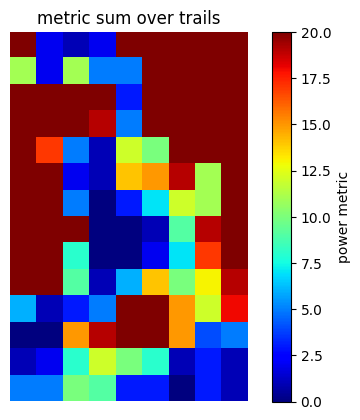

In [19]:

N=10
idx=np.argsort(hilSmo,1)
id=idx[:,-N:]

final=np.zeros_like(hilSmo)
#final[id]=1

row= np.repeat(np.arange(hilSmo.shape[0]),N)
col= id.flatten()
idx=np.ix_(row,col)
final[row,col]=1

final[row,col].shape


median= np.median(hilSmo,axis=1)

metric = (median - 450)

labelssort=np.argsort(metric)
fin = final[labelssort]

inp=fin[:400].sum(0)
pow_img=inp.reshape((14,9))

a=plt.imshow(pow_img,cmap='jet',vmin=0,vmax=20)
plt.colorbar(a,  label="power metric")
plt.axis('off')
plt.title("metric sum over trails")


Text(0.5, 1.0, 'metric value distribution')

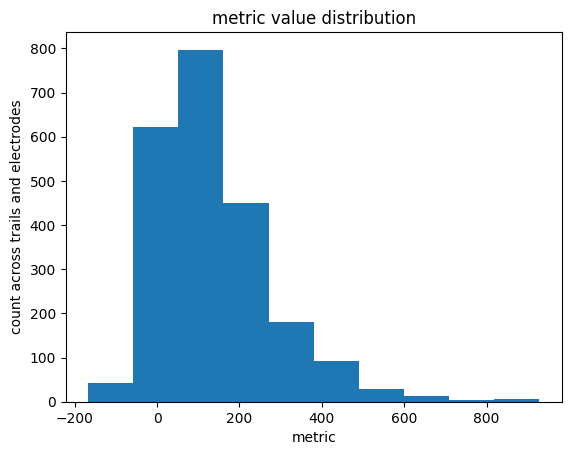

In [18]:
plt.hist(metric[:None])
plt.xlabel("metric")
plt.ylabel("count across trails and electrodes")
plt.title("metric value distribution")

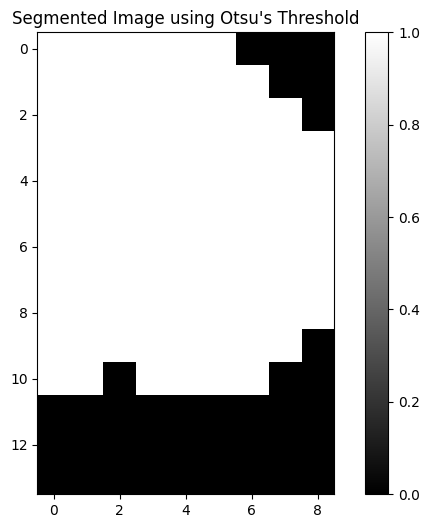

1288.7717415205332


In [ ]:
# threshold and number of pixels:
# max cluster size

from skimage.filters import threshold_otsu

image  = hilSmo_ord[-1].reshape(14,9)
thresh = threshold_otsu(image)

binary_segmented = image> thresh

plt.figure(figsize=(8, 6))
plt.imshow(binary_segmented, cmap='gray')
plt.colorbar()
plt.title("Segmented Image using Otsu's Threshold")
plt.show()

print(thresh)

In [20]:
hilSmo_ord=hilSmo[labelssort]
np.save("images",hilSmo_ord)

Local Spindles and their clusters


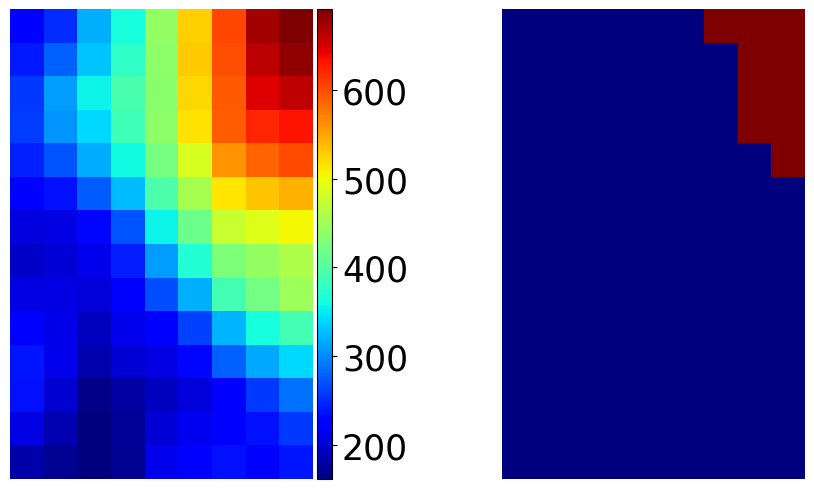

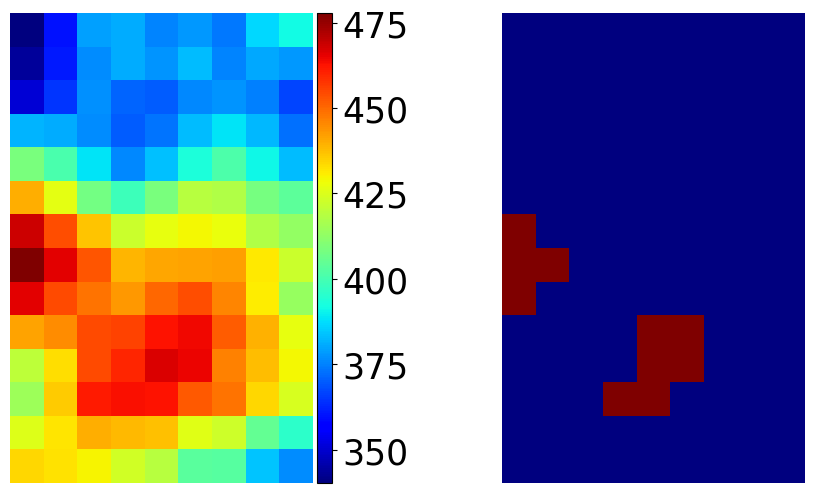

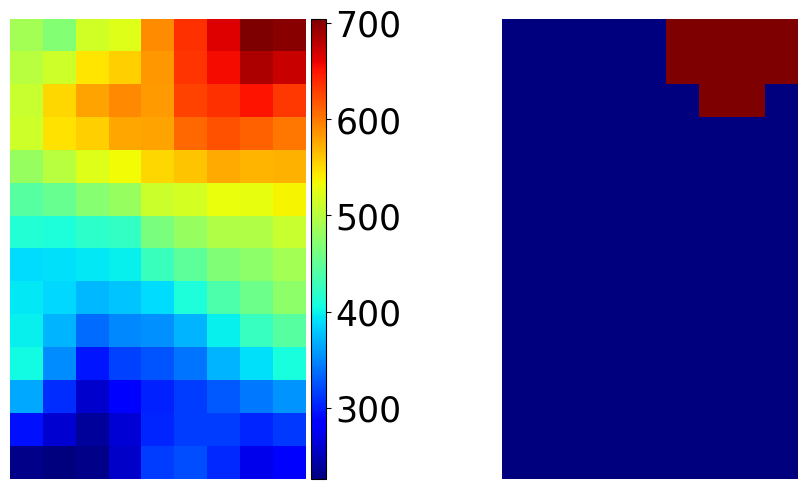

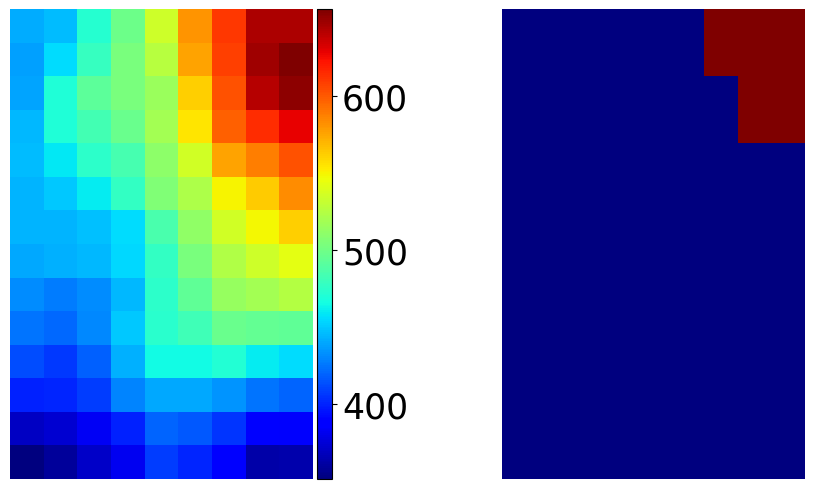

In [27]:
#computes spindle region cluster for each trail

ords=[0,120,250,400]
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
print("Local Spindles and their clusters")
# Sample data since actual data was not provided
for ord in ords:
    inp = hilSmo_ord[ord]
    pow_img = inp.reshape((14, 9))

    fig = plt.figure(figsize=(10,5))

    # First subplot with colorbar
    ax1 = plt.subplot(1, 2, 1)
    a1 = ax1.imshow(pow_img, cmap='jet')
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(a1, cax=cax1)
    #cbar.set_label('Power', rotation=270, labelpad=20)
    cbar.ax.tick_params(labelsize=25)
    ax1.axis("off")

    # Second subplot with colorbar
    inp = fin[ord]
    pow_img = inp.reshape((14, 9))
    ax2 = plt.subplot(1, 2, 2)
    a2 = ax2.imshow(pow_img, cmap='jet', vmin=0)
    # divider2 = make_axes_locatable(ax2)
    # cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    ax2.axis("off")

    plt.tight_layout()
    plt.show()


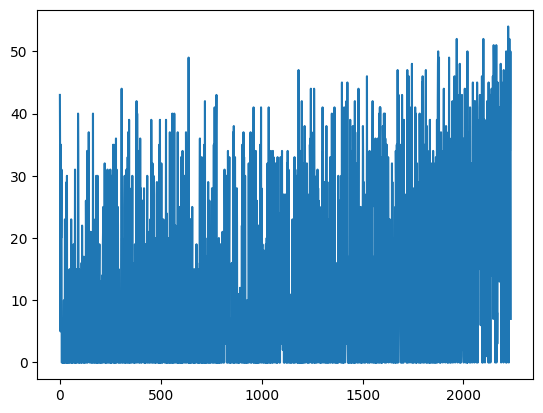

In [28]:
# computes max cluster size for each trail
from scipy.ndimage import label

def max_cluster(image):
    """
    Given a 2D image, compute the size of the largest cluster using only the median as thresholding.
    """
    # Compute the threshold
    threshold = np.median(image)+100

    # Binary thresholding
    binary_image = (image > threshold).astype(int)

    # Connected component labeling
    labeled_image, num_features = label(binary_image)

    # Calculate cluster sizes
    cluster_sizes = [np.sum(labeled_image == i) for i in range(1, num_features + 1)]

    # Return maximum cluster size
    return max(cluster_sizes) if cluster_sizes else 0


max_clusters_sizes =[max_cluster(img.reshape(14, 9)) for img in hilSmo_ord]
plt.plot(max_clusters_sizes)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


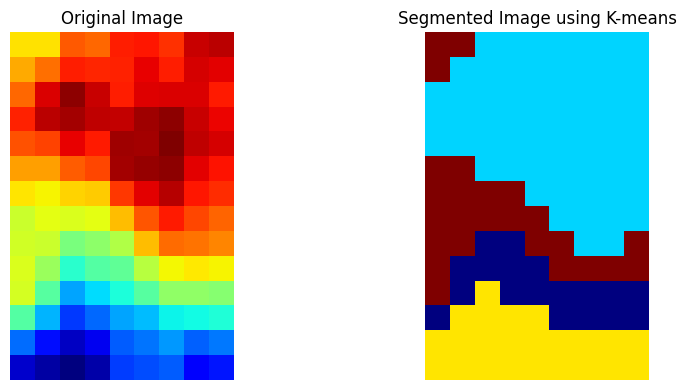

In [39]:
from sklearn.cluster import KMeans

def segment_image_using_kmeans(image, n_clusters=2):
    """
    Segment the given image using k-means clustering.
    """
    # Reshape the image to a 1D array of pixel intensities
    pixels = image.reshape(-1, 1)

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pixels)

    # Reshape the labeled cluster back to the original image shape
    segmented_image = kmeans.labels_.reshape(image.shape)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Original image
    axes[0].imshow(image, cmap='jet')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Segmented image
    axes[1].imshow(segmented_image, cmap='jet')
    axes[1].set_title("Segmented Image using K-means")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()
    return segmented_image,kmeans.labels_

# Segment the sample image using k-means clustering
sample_image=hilSmo_ord[2000].reshape(14,9)
segmented_sample_image,labels = segment_image_using_kmeans(sample_image,4)

# Visualizing the original and segmented images side by side



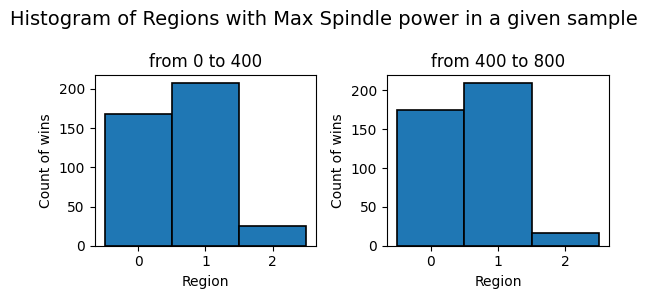

In [44]:

median= np.median(hilbPow,axis=1)

metric = (median - 450)

labelssort=np.argsort(metric)
sortRP=regionPower[labelssort]
srp=maxRP[labelssort]
# for i in range(400,len(sortRP),400):
#     s=sortRP[i-400:i,:].sum(0)
#     plt.plot(s)
#     # # plt.show()
#     # _=plt.hist(srp[i-400:i], bins=np.arange(7), edgecolor='black', linewidth=1.2)
#     plt.title(f"Metric value (from {i-400} to {i})")
#     plt.ylabel("Count of wins")
#     plt.xlabel("Region")

#     plt.show()
data=AgArea
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

for i, ax in enumerate(axes.flatten()):
    ax.hist(srp[400*i:400*(i+1)], bins=np.arange(len(data)+1)-0.5, edgecolor='black', linewidth=1.2)
    ax.set_title(f"from {400*i} to {400*(i+1)}")
    ax.set_xlabel("Region")
    ax.set_ylabel("Count of wins")
    ax.set_xticks(np.arange(len(data)))

fig.suptitle("Histogram of Regions with Max Spindle power in a given sample",size=14)
plt.tight_layout()
plt.show()

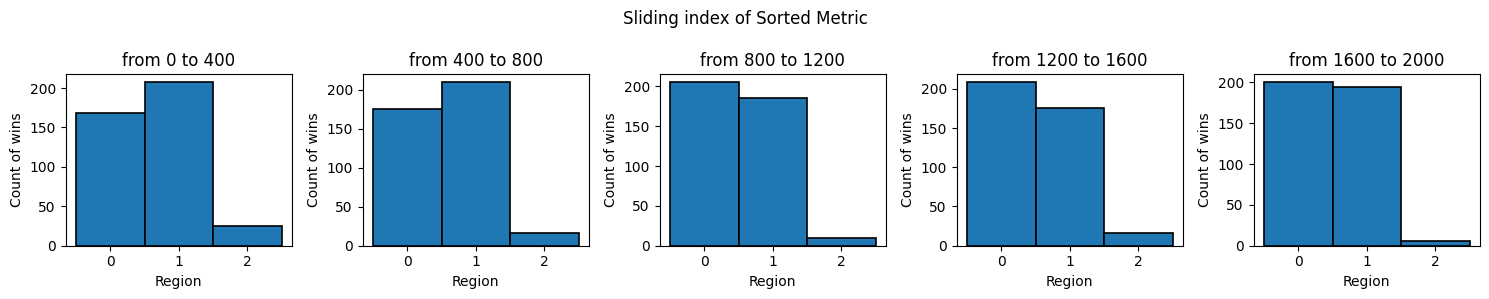

In [43]:
median= np.median(hilbPow,axis=1)

metric = (median - 450)

labelssort=np.argsort(metric)
sortRP=regionPower[labelssort]
srp=maxRP[labelssort]

data=AgArea
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))


for i, ax in enumerate(axes.flatten()):
    ax.hist(srp[400*i:400*(i+1)], bins=np.arange(len(data)+1)-0.5, edgecolor='black', linewidth=1.2)

    # ax.imshow()
    ax.set_title(f"from {400*i} to {400*(i+1)}")
    ax.set_xlabel("Region")
    ax.set_ylabel("Count of wins")
    ax.set_xticks(np.arange(len(data)))
fig.suptitle("Sliding index of Sorted Metric")
plt.tight_layout()
plt.show()

In [45]:
def hilbertLbl(path,save=True):
    #20200220post train
    spindle_path=path+'_Hilbert_features.mat'

    spindle_raw=loadmat(spindle_path)
    hilbPow=(np.hstack(np.concatenate(spindle_raw["Hilbert"]['pow']))).T
    hilbPow = np.where(hilbPow>=2000,2000,hilbPow)
     #numpy array spindles x 126

    sorted= np.sort(hilbPow,axis=1)
    median= np.median(sorted[:,:50],axis=1)

    labels = (median - 450) >100
    label10=np.zeros(labels.shape[0])
    hilbPow = (hilbPow -450)/(1500-450)
    label10[labels]=1
    results=[]
    results.append(hilbPow)
    results.append(labels)
    results.append(median)


    if save==True:
        [head,tail]=os.path.split(path)
        if not os.path.exists(head+'/Hilbert_norm'):
            os.makedirs(head+'/Hilbert_norm')
        resfile=head+'/Hilbert_norm/'+tail+'_hilbnorm.npz'
        np.savez(resfile,x=hilbPow,y=label10,median=median)

    return results

def matchSpiRip(path,save=True):

    #train_files = [x for x in glob.glob(os.path.join(data_folder, "train_-_*")) if os.path.basename(x).split("_-_")[-1].split(".")[0] in features]

    ripple_path=glob.glob(path+'*HC_NREM_ripples.mat')[0]
    spindle_path=path+'_TF_features.mat'



    ripples_raw=loadmat(ripple_path)
    ripple_times=ripples_raw["ripples_Hc"]

    spindle_raw=loadmat(spindle_path)
    spindle_times=np.concatenate(spindle_raw["features"]['spi'][0])

    r=ripple_times[:,1]  #ripple_mid
    s=spindle_times[:,0] #spindle_mid
    threshold=0.5

    s_lb=s-threshold
    s_ub=s+threshold


    match=np.where((r[:,None]<s_ub[None,:]) & (r[:,None]>s_lb[None,:]))

    ma2= r[:,None]-s[None,:]
    ind=np.argmin(np.abs(ma2),axis=0)

    ripple_match=r[match[0]]
    spindle_match=s[match[1]]
    time_dif=ripple_match-spindle_match

    z=np.zeros((s_lb.shape))
    z[match[1]]=1

    results=np.full((6,)+s.shape,np.nan)
    results[0]=s
    results[1]=z
    results[2]=r[ind]
    results[3]=s-r[ind]
    results[4]=(np.abs(results[3])<threshold)


    if save==True:
        [head,tail]=os.path.split(path)
        if not os.path.exists(head+'/Results'):
            os.makedirs(head+'/Results')
        resfile=head+'/Results/'+tail+'_results.mat'
        savemat(resfile,{"results":results})

    return results


In [ ]:
#process data across all animals, generate normalised hilbert powers and metrics

from tqdm import tqdm
animals= glob.glob('/content/drive/MyDrive/Spindles/Raw_Data/forPID/*')

maxi=[]
mini=[]
medi=[]
i=0
lbl=np.array([],dtype=bool)
for animal in animals:
    roots=[os.path.join(animal, '_'.join(os.path.basename(x).split("_")[:3])) for x in glob.glob(animal+'/*_Hilbert_features.mat')]
    for root in roots:

        if root != "/content/drive/MyDrive/Spindles/Raw_Data/forPID/OR17/20200202_0um_posttrain":
            results= hilbertLbl(root)
            maxi=np.concatenate((maxi,np.max(results[0],axis=1)))
            mini=np.concatenate((mini,np.min(results[0],axis=1)))
            medi=np.concatenate((medi,np.median(results[0],axis=1)))
            lbl = np.concatenate((lbl,results[1]))
            i+=1


print(i)


# MIN MAX separation across animals

Text(0.5, 1.0, '"global" spindle distribution')

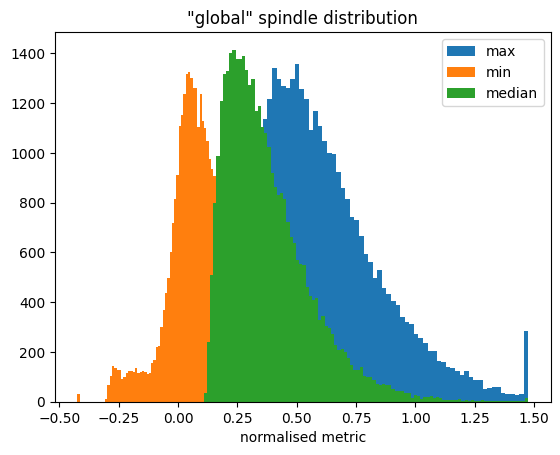

In [55]:
import matplotlib.pyplot as plt

_=plt.hist(maxi[lbl], bins='auto')
_=plt.hist(mini[lbl], bins='auto')
_=plt.hist(medi[lbl], bins='auto')
plt.xlabel("normalised metric")
plt.legend(['max','min','median'])
plt.title("\"global\" spindle distribution")

# CONCLUSION: Local and Global distributions do not have clear distinction and almost merge into each other as if part of a larger distribution.

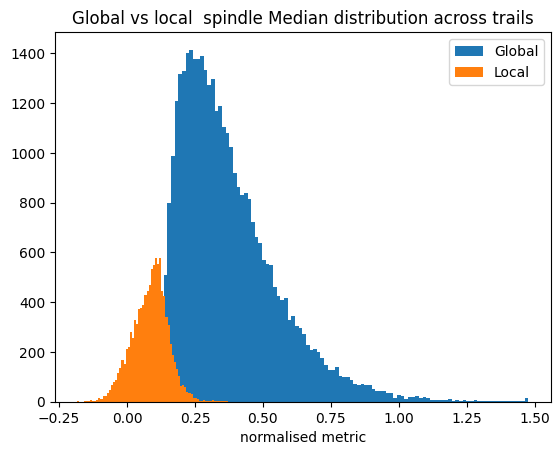

In [57]:
plt.title("Global vs local  spindle Median distribution across trails")
plt.xlabel("normalised metric")
_=plt.hist(medi[lbl], bins='auto',label="Global")
_=plt.hist(medi[~ lbl], bins='auto',label="Local")
plt.legend()

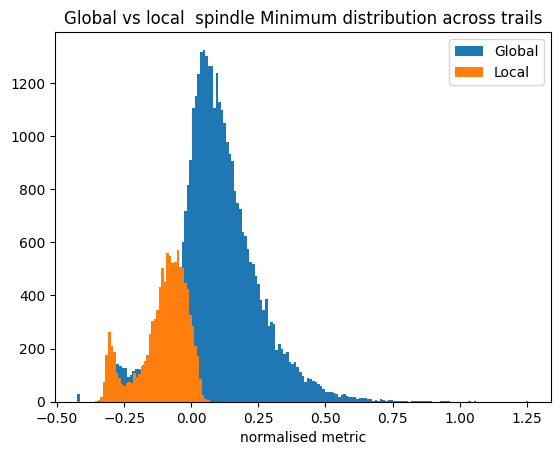

In [58]:
plt.title("Global vs local  spindle Minimum distribution across trails")
plt.xlabel("normalised metric")
_=plt.hist(mini[lbl], bins='auto',label="Global")
_=plt.hist(mini[~ lbl], bins='auto',label="Local")
plt.legend()

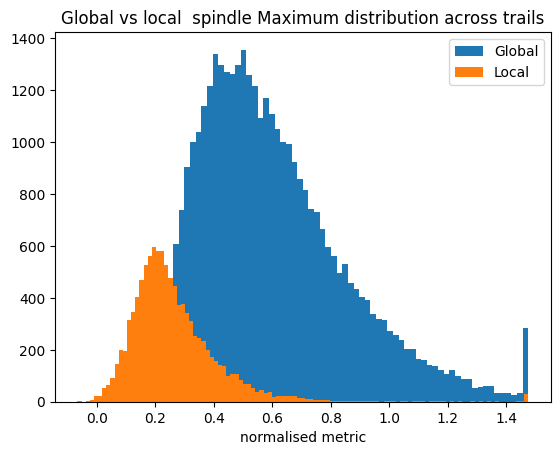

In [59]:
plt.title("Global vs local  spindle Maximum distribution across trails")
plt.xlabel("normalised metric")
_=plt.hist(maxi[lbl], bins='auto',label="Global")
_=plt.hist(maxi[~ lbl], bins='auto',label="Local")
plt.legend()

#OLD CODE

In [ ]:
matlab_variables=loadmat("/content/drive/MyDrive/Spindles/Raw_Data/forPID/OR17/Results/20200220_0um_posttrain_results.mat")
matlab_variables["results"].shape


(5, 2236)

In [ ]:
pow=np.hstack(np.concatenate(matlab_variables['features']['pow']))
import matplotlib.pyplot as plt

pow_img=pow[:,0].reshape((14,9))

plt.imshow(pow_img)

In [ ]:
class plot_base:

    def __init__(self,inst,ax,title=None,xlabel=None,ylabel=None,xlimits=[None,None],ylimits=[None,None],figure=None):
        self.ax =ax
        self.ax.title.set_text(title)
        self.ax.set_xlim(xlimits[0],xlimits[1])
        self.ax.set_ylim(ylimits[0],ylimits[1])

        if  xlimits==[None,None]: self.ax.set_xlim(auto=True)
        if  ylimits==[None,None]: self.ax.set_ylim(auto=True)

        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)

    def show(self):
        raise NotImplementedError("subclass needs to implement this")



class heatmap(plot_base):
    def __init__(self, instance, ax, title=None, xlabel=None, ylabel=None, xlimits=[None,None], ylimits=[None,None],vmin=None,vmax=None,figure=None):
        title = title + "heatmap"
        super().__init__(instance, ax, title, xlabel, ylabel, xlimits, ylimits,figure)

        a=self.ax.imshow(instance, cmap='jet', vmin=vmin, vmax=vmax)
        figure.colorbar(a,ax=self.ax)







def visualize_functions(spindles,num=1, changes=[], figure_size=(20,20)):
    instance_count, dim1, dim2 = spindles.shape
    change_count = len(changes)
    instance_count = min( instance_count,num)

    fig, axs = plt.subplots(instance_count, change_count, figsize=figure_size)
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.7,top=0.7,wspace=0.6,hspace=0.5)

    for i, instance in enumerate(spindles):
        for j, change in enumerate(changes):
            obj = change(instance,axs[i,j],title="spindle{} ".format(i),figure=fig)

    #plt.show()


In [ ]:
po=np.vstack((pow_img[None,:,:],pow_img[None,:,:]))
visualize_functions(po,num=2, changes=[heatmap,heatmap,heatmap], figure_size=(10,10))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)

for i in range(2):
    for j in range(2):
        im = axs[i, j].imshow(np.random.rand(10, 10))
        fig.colorbar(im, ax=axs[i, j])

plt.show()